In [1]:

# Importy bibliotek
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Sprawdzenie wersji TensorFlow (opcjonalne, ale przydatne)
print(f"Wersja TensorFlow: {tf.__version__}")

Wersja TensorFlow: 2.20.0


In [2]:
# Załadowanie zestawu danych MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizacja danych: skalowanie wartości pikseli z [0, 255] do [0.0, 1.0]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Zmiana kształtu danych dla sieci CNN (dodanie wymiaru kanału: (28, 28) -> (28, 28, 1))
x_train = x_train[..., tf.newaxis].astype(np.float32)
x_test = x_test[..., tf.newaxis].astype(np.float32)

# Konwersja etykiet na format one-hot encoding (np. 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print(f"Kształt danych treningowych (obrazy): {x_train.shape}")
print(f"Kształt danych treningowych (etykiety): {y_train.shape}")

Kształt danych treningowych (obrazy): (60000, 28, 28, 1)
Kształt danych treningowych (etykiety): (60000, 10)


In [3]:
# Funkcja do tworzenia prostego modelu CNN
def create_cnn_model():
    model = tf.keras.Sequential([
        # Warstwa konwolucyjna: 32 filtry 3x3, ReLU, oczekiwany kształt wejściowy (28, 28, 1)
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        # Warstwa Max Pooling: redukcja wymiarów 2x2
        tf.keras.layers.MaxPooling2D((2, 2)),
        # Druga warstwa konwolucyjna: 64 filtry 3x3, ReLU
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        # Druga warstwa Max Pooling
        tf.keras.layers.MaxPooling2D((2, 2)),
        # Spłaszczenie danych do jednowymiarowego wektora
        tf.keras.layers.Flatten(),
        # Warstwa gęsta (fully connected): 128 jednostek, ReLU
        tf.keras.layers.Dense(128, activation='relu'),
        # Warstwa wyjściowa: 10 jednostek (klas), Softmax (dystrybucja prawdopodobieństwa)
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Kompilacja modelu: optymalizator Adam, funkcja straty Cross-Entropy dla klasyfikacji
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Stworzenie i wytrenowanie początkowego modelu
print("Rozpoczęcie treningu modelu bazowego...")
model = create_cnn_model()
history = model.fit(x_train, y_train, epochs=3, validation_split=0.1, batch_size=64, verbose=1)

print("\n Trening modelu bazowego zakończony.")

Rozpoczęcie treningu modelu bazowego...
Epoch 1/3


C:\Users\Damian\Desktop\AdAttackCourse\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9499 - loss: 0.1692 - val_accuracy: 0.9843 - val_loss: 0.0532
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9841 - loss: 0.0516 - val_accuracy: 0.9875 - val_loss: 0.0475
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9885 - loss: 0.0361 - val_accuracy: 0.9895 - val_loss: 0.0404

 Trening modelu bazowego zakończony.


In [ ]:
#Ocena Modelu Bazowego

# Ocena modelu na czystym (niezaatakowanym) zbiorze testowym
print("Ocena modelu bazowego na czystym zbiorze testowym:")
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Strata (Loss): {loss:.4f}, Dokładność (Accuracy): {accuracy:.4f}")

In [4]:
#Implementacja Ataku FGSM

# Funkcja do generowania wzorca adwersarialnego (Signed Gradient)
@tf.function
def create_adversarial_pattern(input_image, input_label):
    """
    Oblicza znak gradientu funkcji straty względem obrazu wejściowego.
    """
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        # Rejestrowanie operacji na obrazie, aby móc obliczyć gradient
        tape.watch(input_image)
        # Przewidywanie modelu
        prediction = model(input_image)
        # Obliczenie straty
        loss = loss_object(input_label, prediction)

    # Obliczenie gradientu straty względem obrazu wejściowego
    gradient = tape.gradient(loss, input_image)
    # Wyodrębnienie znaku z każdego elementu gradientu
    signed_grad = tf.sign(gradient)
    return signed_grad

# Funkcja do tworzenia zbioru adwersarialnych przykładów
def augment_with_adversarial_examples(model, x_data, y_data, epsilon=0.5):
    """
    Generuje przykłady adwersarialne(zwodnicze) na podstawie zbioru danych x_data i y_data,
    używając epsilon jako wskaźnika siły ataku.
    """
    x_data_adv = []

    # Iteracja po wszystkich przykładach w zbiorze danych
    for i in range(len(x_data)):
        image = x_data[i]
        label = y_data[i]

        # Konwersja obrazu i etykiety na tensory z wymiarem wsadowym (batch dim)
        image_tensor = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)), dtype=tf.float32)
        label_tensor = tf.convert_to_tensor(label.reshape((1, 10)), dtype=tf.float32)

        # Obliczenie perturbacji FGSM
        perturbations = create_adversarial_pattern(image_tensor, label_tensor)

        # Stworzenie obrazu adwersarialnego: obraz + epsilon * perturbacja
        adversarial_image = image_tensor + epsilon * perturbations

        # Przycięcie wartości pikseli do prawidłowego zakresu [0, 1]
        adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)

        # Dodanie obrazu do listy (usunięcie wymiaru wsadowego)
        x_data_adv.append(adversarial_image.numpy().squeeze(0))

    return np.array(x_data_adv)

# Definicja siły ataku
epsilon_fgsm = 0.5

print(f"Generowanie adwersarialnych przykładów treningowych z epsilon={epsilon_fgsm}...")
# Generowanie adwersarialnych przykładów dla zbioru treningowego
x_train_adv = augment_with_adversarial_examples(model, x_train, y_train, epsilon=epsilon_fgsm)

print(f"Kształt adwersarialnych danych treningowych: {x_train_adv.shape}")

Generowanie adwersarialnych przykładów treningowych z epsilon=0.5...
Kształt adwersarialnych danych treningowych: (60000, 28, 28, 1)


In [5]:
#Trening Adwersarialny

# Połączenie czystych i adwersarialnych danych treningowych
x_train_combined = np.vstack([x_train, x_train_adv])
y_train_combined = np.vstack([y_train, y_train])

print(f"Łączny kształt treningowy (czyste + adwersarialne): {x_train_combined.shape}")

# Retrening nowego modelu na rozszerzonym zbiorze danych
print("\nRozpoczęcie TRENINGU ADWERSARIALNEGO...")
model_adv = create_cnn_model()
history_adv = model_adv.fit(x_train_combined, y_train_combined, epochs=3, validation_split=0.1, batch_size=64, verbose=1)

print("\n Trening Adwersarialny zakończony.")

Łączny kształt treningowy (czyste + adwersarialne): (120000, 28, 28, 1)

Rozpoczęcie TRENINGU ADWERSARIALNEGO...
Epoch 1/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9337 - loss: 0.2194 - val_accuracy: 0.9819 - val_loss: 0.0621
Epoch 2/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9838 - loss: 0.0539 - val_accuracy: 0.9872 - val_loss: 0.0421
Epoch 3/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9894 - loss: 0.0335 - val_accuracy: 0.9898 - val_loss: 0.0329

 Trening Adwersarialny zakończony.


In [6]:
#Ocena Odporności Modelu Po Treningu Adwersarialnym

# 1. Ocena na czystym zbiorze testowym
print("\n### 1. Ocena na CZYSTYCH DANYCH TESTOWYCH ###")
loss_clean_adv, acc_clean_adv = model_adv.evaluate(x_test, y_test, verbose=0)
print(f"Strata: {loss_clean_adv:.4f}, Dokładność: {acc_clean_adv:.4f}")

# 2. Generowanie adwersarialnych przykładów dla zbioru testowego (przy użyciu NOWEGO modelu)
print(f"\nGenerowanie adwersarialnych przykładów testowych z epsilon={epsilon_fgsm} dla modelu_adv...")
x_test_adv = augment_with_adversarial_examples(model_adv, x_test, y_test, epsilon=epsilon_fgsm)

# 3. Ocena na adwersarialnym zbiorze testowym
print("\n### 2. Ocena na ADWERSARIALNYCH DANYCH TESTOWYCH (bez obrony) ###")
loss_adv_adv, acc_adv_adv = model_adv.evaluate(x_test_adv, y_test, verbose=0)
print(f"Strata: {loss_adv_adv:.4f}, Dokładność: {acc_adv_adv:.4f}")

print("\nPorównaj te wyniki z wynikami modelu bazowego na tych samych atakach (dokładność modelu_adv powinna być wyższa).")


### 1. Ocena na CZYSTYCH DANYCH TESTOWYCH ###
Strata: 0.0401, Dokładność: 0.9868

Generowanie adwersarialnych przykładów testowych z epsilon=0.5 dla modelu_adv...

### 2. Ocena na ADWERSARIALNYCH DANYCH TESTOWYCH (bez obrony) ###
Strata: 0.0297, Dokładność: 0.9898

Porównaj te wyniki z wynikami modelu bazowego na tych samych atakach (dokładność modelu_adv powinna być wyższa).



### 3. Ocena na PRZETWORZONYCH (Przyciętych) ADWERSARIALNYCH DANYCH TESTOWYCH ###
Strata: 0.0297, Dokładność: 0.9898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


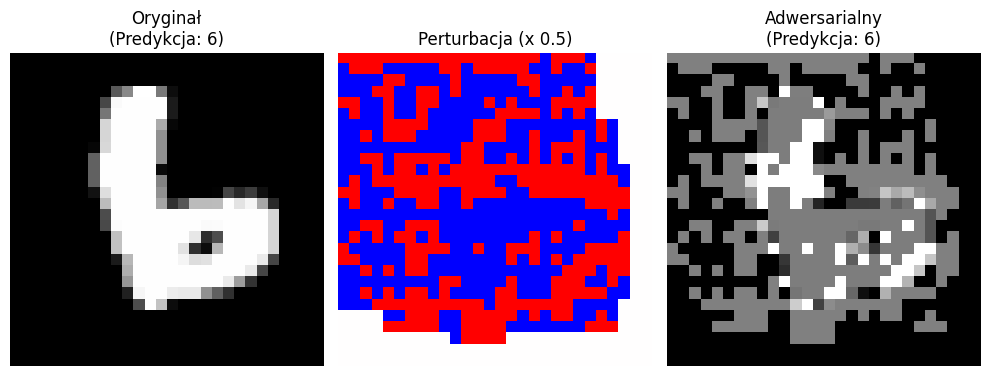

In [7]:
#Dodatkowa Obrona: Przycinanie Wartości Wejściowych (Input Preprocessing Defense - Clipping)

# Przycięcie (clipping) wartości pikseli w adwersarialnych przykładach do zakresu [0, 1]
# Chociaż FGSM już to robi, jest to standardowa prosta technika obronna.
x_test_adv_clipped = np.clip(x_test_adv, 0.0, 1.0)

# Ocena modelu po treningu adwersarialnym na przyciętych adwersarialnych danych testowych
print("\n### 3. Ocena na PRZETWORZONYCH (Przyciętych) ADWERSARIALNYCH DANYCH TESTOWYCH ###")
loss_clip_adv, acc_clip_adv = model_adv.evaluate(x_test_adv_clipped, y_test, verbose=0)
print(f"Strata: {loss_clip_adv:.4f}, Dokładność: {acc_clip_adv:.4f}")

# Wizualizacja (Opcjonalne)
def display_adversarial_image(original, adversarial, prediction_orig, prediction_adv, perturbation):
    plt.figure(figsize=(10, 4))

    # Oryginalny obraz
    plt.subplot(1, 3, 1)
    plt.title(f"Oryginał\n(Predykcja: {np.argmax(prediction_orig)})")
    plt.imshow(original.squeeze(), cmap='gray')
    plt.axis('off')

    # Perturbacja
    plt.subplot(1, 3, 2)
    plt.title("Perturbacja (x " + str(epsilon_fgsm) + ")")
    # Skalowanie kolorów perturbacji
    plt.imshow(perturbation.numpy().squeeze(), cmap='bwr', vmin=-1, vmax=1)
    plt.axis('off')

    # Obraz adwersarialny
    plt.subplot(1, 3, 3)
    plt.title(f"Adwersarialny\n(Predykcja: {np.argmax(prediction_adv)})")
    plt.imshow(adversarial.squeeze(), cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Wybór losowego przykładu do wizualizacji
idx = np.random.randint(0, len(x_test_adv))
orig_image = x_test[idx]
adv_image = x_test_adv[idx]
label = y_test[idx]

# Generowanie perturbacji dla wizualizacji
image_tensor = tf.convert_to_tensor(orig_image.reshape((1, 28, 28, 1)), dtype=tf.float32)
label_tensor = tf.convert_to_tensor(label.reshape((1, 10)), dtype=tf.float32)
perturbation = create_adversarial_pattern(image_tensor, label_tensor)

# Przewidywanie modelu_adv
pred_orig = model_adv.predict(orig_image[tf.newaxis, ...])
pred_adv = model_adv.predict(adv_image[tf.newaxis, ...])

display_adversarial_image(orig_image, adv_image, pred_orig, pred_adv, perturbation)